In [1]:
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
import logging
import json
logging.disable(logging.INFO)

import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

# Data Pre-processing

## Data importing

In [2]:
# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
# Create prelim df with filename and target emotion class (mood)
data_path = 'dataset/ck/'
model_path = 'trained_models/'
moods = [k for k in os.listdir(data_path) if '.' not in k]

Only for vectors.

In [4]:
# init vectors & coords df
data = []
for mood in moods:
    for filename in os.listdir(data_path + mood):
        data.append([filename, mood])
df = pd.DataFrame(data, columns=['filename','mood'])
df.set_index('filename', inplace=True)
df["vectors"] = [np.array([]) for k in range(df.shape[0])]
df["coords"] = [np.array([]) for k in range(df.shape[0])]
display(df.sample(10))

,mood,vectors,coords
filename,,,
S091_001_00000001.png,neutral,[],[]
S126_004_00000012.png,surprise,[],[]
S125_007_00000001.png,neutral,[],[]
S084_002_00000001.png,neutral,[],[]
S045_005_00000001.png,neutral,[],[]
S068_005_00000001.png,neutral,[],[]
S106_002_00000001.png,neutral,[],[]
S061_004_00000001.png,neutral,[],[]
S022_001_00000001.png,neutral,[],[]


In [5]:
# Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

## Feature Extraction - Vectors
The cell below takes awhile.

anger
S010_004_00000019.png


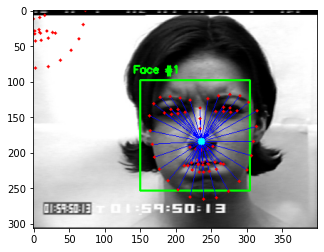

contempt
S138_008_00000009.png


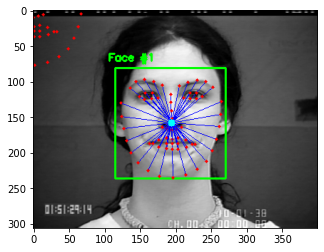

disgust
S005_001_00000011.png


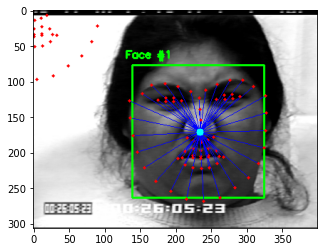

fear
S011_003_00000014.png


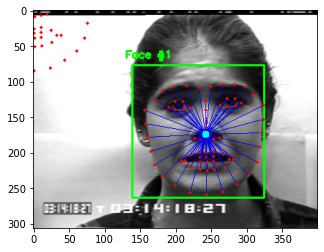

happiness
S010_006_00000015.png


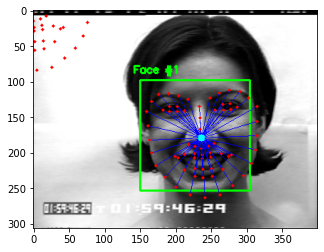

neutral
S005_001_00000001.png


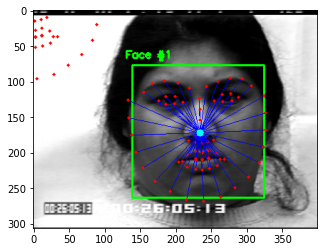

sadness
S011_002_00000022.png


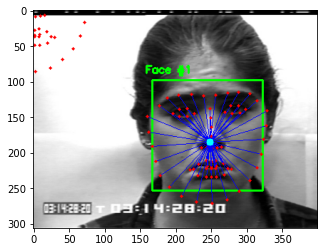

surprise
S010_002_00000014.png


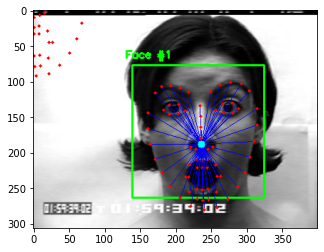

In [7]:
# Populate df with (reshaped) vector data
features = {}
for mood in moods:
    features[mood] = []
    print(mood)
    show = True # show only the first image of each emotion
    for filename in os.listdir(data_path + mood):
        path = data_path + mood + '/' + filename
        vectors = [] # list of vectors
        coords = [] # list of coordinates of facial landmarks (offset by cog)
        
        # load the input image, resize it, and convert it to grayscale
        image = cv2.imread(path)
        image = imutils.resize(image, width=400)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY
        gray = cv2.equalizeHist(gray)

        # detect faces in the grayscale image
        rects = detector(gray, 1)
        
        if not len(rects):
            print(filename)
            df.drop(index=filename)
            continue            

        # loop over the face detections (multiple faces)
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect) # determine facial landmarks for face region
            shape = face_utils.shape_to_np(shape) # convert the facial landmark (x,y)-coordinates to a Numpy array

            if show:
                (x,y,w,h) = face_utils.rect_to_bb(rect) # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x,y,w,h)]
                cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2) # draw the face bounding box
                cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) # show face number
            
            cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)            

            # draw (x,y)-coordinates for the facial landmarks on image
            for (x,y) in shape:
                if show:
                    cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
                    cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
                vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction                
                coords.append([x-cog[0], y-cog[1]]) # append coordinates relative to cog
            if show:
                cv2.circle(image, cog, 5, (0,255,255), -1)                
        
        # show the output image with the face detections + facial landmarks
        if show:
            print(filename)
            plt.imshow(image) # adapted for jupyter
            plt.show()    
        break
        
        # store inputs in dataset
        vectors = np.array(vectors)        
        scale_factor = 1 / max(vectors[:,0])
        vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
#         vectors = vectors[:,0] * vectors[:,1]
        df.loc[filename, 'vectors'] = vectors
    
        coords = np.array(coords) * scale_factor
        coords = coords.reshape(-1)
        df.loc[filename, 'coords'] = coords
        
        show = False        
        

In [8]:
df.sample(5)

,mood,vectors,coords
filename,,,
S057_006_00000033.png,happiness,"[[0.9154871114530281, -2.672327126164032], [0....","[-0.8165235774587036, -0.4140119547677934, -0...."
S110_005_00000001.png,neutral,"[[0.9671561468108908, -2.666249671423298], [0....","[-0.8599331643664843, -0.4426126581298081, -0...."
S115_004_00000001.png,neutral,"[[0.9294655247362655, -2.775337093159016], [0....","[-0.86781858771699, -0.3328619240558318, -0.83..."
S148_002_00000001.png,neutral,"[[0.9387162078135656, -2.707348332792992], [0....","[-0.8515922991792054, -0.3949413561410808, -0...."
S055_005_00000045.png,happiness,"[[1.0, -2.7781995200945624], [0.93497421163891...","[-0.9346961248202004, -0.3554478221147241, -0...."


In [101]:
# Filter df
indexNames = df[(df.vectors.str.len().eq(0)) | (df.coords.str.len().eq(0))].index 
indexNames = list(indexNames)
for index,row in df.iterrows():
    if len(row['vectors']) != 68:
        indexNames.append(index)
print(len(indexNames))
df_cpy = df.drop(indexNames, inplace=False)

# Save df with vectors and coords to CSV
# df['vectors'] = df['vectors'].apply(lambda x:list(x)).apply(json.dumps)
df_cpy['vectors'] = [[list(sample[i]) for i in range(68)] for sample in [list(k) for k in df_cpy['vectors'].to_numpy()]].apply(json.dumps)
df_cpy['coords'] = df_cpy['coords'].apply(lambda x:list(x)).apply(json.dumps)
df_cpy.to_csv(data_path + 'df_vector_coods_sep.csv')

0


## Feature extraction - Cropped Faces

In [7]:
moods = [k for k in moods if k != 'contempt']
print(moods)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


anger
S010_004_00000019.png


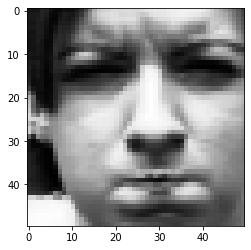

disgust
S005_001_00000011.png


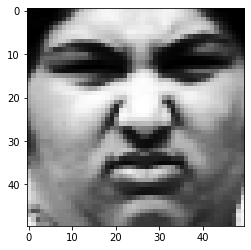

fear
S011_003_00000014.png


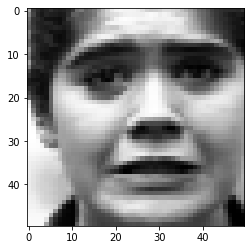

happiness
S010_006_00000015.png


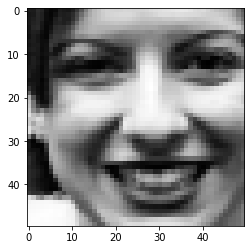

neutral
S005_001_00000001.png


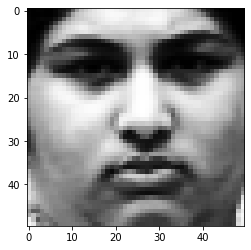

sadness
S011_002_00000022.png


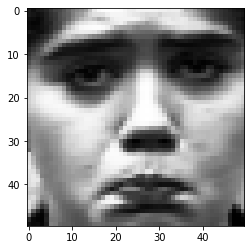

surprise
S010_002_00000014.png


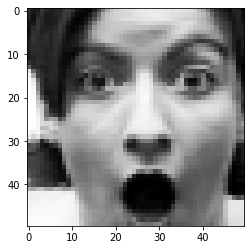

Time taken: 1m35s.


In [28]:
dim = 50
cropped_dataset, cropped_target = [], [] # dataset.shape=(num_datapoints, 100, 100)
brk = False
lst = []
start = time.time()
for mood in moods:
    print(mood)
    show = True # show only the first image of each emotion
    for filename in os.listdir(data_path + mood):
        path = data_path + mood + '/' + filename
        
        try:
            # load the input image, resize it, and convert it to grayscale
            image = cv2.imread(path)
            image = imutils.resize(image, width=400)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # detect faces in the grayscale image
            rects = detector(gray, 1)

            # loop over the face detections (multiple faces)
            for (i, rect) in enumerate(rects):
                # determine the facial landmarks for the face region, then
                # convert the facial landmark (x,y)-coordinates to a NumPy array
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape) 

                # convert dlib's rectangle to a OpenCV-style bounding box
                # [i.e., (x, y, w, h)], then draw the face bounding box
                (x,y,w,h) = face_utils.rect_to_bb(rect)
                cropped_image = image[y:y+h, x:x+w]
                cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY) # remove axis
                cropped_image = cv2.equalizeHist(cropped_image)

            # resize and square-crop cropped face
            cropped_image = imutils.resize(cropped_image, width=int(dim*1.05)) # buffer for cropping
            cropped_image = cropped_image[:dim,:dim]
            if cropped_image.shape[0]!=dim or cropped_image.shape[1]!=dim:
                raise Exception()
#                 print(filename, cropped_image.shape)
        
            # show the output image with the face detections + facial landmarks
            if show:
                print(filename)
                plt.imshow(cropped_image, cmap='gray') # adapted for jupyter
                plt.show()

            show = False

        except:
            print('[ERROR]', filename)
            lst.append((mood, filename))
            
        # add to dataset
        cropped_image = cropped_image.reshape(1,dim,dim)
        cropped_dataset.append(cropped_image)
        cropped_target.append(mood)
            
end = time.time()
tt = end - start
print("Time taken: %dm%ds." % (tt//60, tt%60))
cropped_dataset = np.array(cropped_dataset)
cropped_target = np.array(cropped_target)

In [30]:
print(cropped_dataset.shape)
print(cropped_target.shape)

(902, 1, 50, 50)
(902,)


In [31]:
# Save image graylevels arrays
with open(data_path + 'graylevels_data_no_contempt.npy', 'wb') as f:
    np.save(f, cropped_dataset)
    np.save(f, cropped_target)